## **Set 4 (HD Tasks) Investigating Neural Collapse in Deep Learning**

### Task 4.1 Examine layer rotation with Layca

1. Reproduce experiments described in the paper [Layer rotation: a surprisingly powerful indicator of generalization in deep networks?](https://arxiv.org/abs/1806.01603),  Compare the results you obtained with the ones in the paper. Do you identify any discrepancies?

2. What connections do you discover between the paper and what you have learnt in the unit?

### Task 4.2 Design and Develop Your Own ML Solution
1. Design and develop your own deep learning solution using CIFAR dataset. The proposed solution must be substantially different from the approaches presented in the article. However, this does not mean you are required to choose a new ML algorithm. You can develop a novel solution by changing the feature
selection approach, using different preprocessing techniques, exploring alternative model combinations, or restructuring the training pipeline. The goal is to propose a system that is meaningfully distinct from the authors' method.
Your technical report must include:
* A clear motivation for the proposed solution
* A description of how your method differs from the article
* A well-structured experimental protocol
* Evaluation using Accuracy, Precision, Recall, F1 Score, and AUC.

### Deliverables for HD Tasks

* Written submission (Max 4 pages): Summarize your approach to reproducing the experiments, key findings, and critical observations. Clearly articulate the research gaps or failure cases you identified.
* Link to reproducible code
* Short video presentation (Max 5 minutes): Highlight your main conclusions about neural collapse.
Discuss the most pressing research gaps or failure cases and how addressing them could push the field forward.

### Import Module

In [65]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload
%autoreload
import sys
sys.path.insert(0, "../")

import warnings
import os
import time

import math as m
import numpy as np
np.random.seed(1)

import matplotlib
import matplotlib.pyplot as plt
import pickle

from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.models import Model

# Force reload of layca_optimizers to pick up fixes
import importlib
if 'layca_optimizers' in sys.modules:
    importlib.reload(sys.modules['layca_optimizers'])
from layca_optimizers import SGD

from keras.callbacks import LearningRateScheduler

from experiment_utils import plot_history, history_todict
from layer_rotation_utils import LayerRotationCurves, plot_layer_rotation_curves
from experiment_utils import lr_schedule

from feature_visualization import visualize_1stlayer_weights
from utils import load_reduced_mnist_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# utilities for storing the results in pickle files
result_file = 'results.p'
def load_results():
    if not os.path.isfile(result_file):
        return {}
    else:
        with open(result_file,'rb') as f:
            return pickle.load(f)

def dump_results(results):
    with open(result_file,'wb') as f:
        pickle.dump(dict(results),f)

def update_results(path, new_data):
    results = load_results()
    position = results
    for p in path:
        position = position[p]
    # new_data is a dictionary with the new (key,value) pairs
    position.update(new_data)
    dump_results(results)

def get_aspect(ax=None):  # used to compute rotation of text here under
    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio / ax.get_data_ratio()

    return aspect

# if results should be saved in the file or not
save_results = True
if not save_results:
    results = {}

### Create Train Data

In [67]:
x_train, y_train, x_test, y_test = load_reduced_mnist_data(samples_per_class = 1000)

def get_model():
    inp = Input((784,))
    x = Dense(784, activation = 'linear', name = 'dense0')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(10, activation = 'softmax', name = 'densef')(x)
    return Model(inp,x)

# configuration of the different learning rate schedules 
# (a division of the learning rate by 5 is used to escape plateaus in the loss curve)
training_configs = {3**-2: (100, LearningRateScheduler(lr_schedule(3**-2,1./5.,[90]))),
                    3**-2.5: (100, LearningRateScheduler(lr_schedule(3**-2.5,1./5.,[95]))),
                    3**-3: (100, LearningRateScheduler(lr_schedule(3**-3,1./5.,[95]))),
                    3**-4: (100, LearningRateScheduler(lr_schedule(3**-4,1.,[np.inf]))),
                    3**-5: (120, LearningRateScheduler(lr_schedule(3**-5,1.,[np.inf]))),
                    3**-6: (300, LearningRateScheduler(lr_schedule(3**-6,1.,[np.inf]))),
                    3**-7: (1000, LearningRateScheduler(lr_schedule(3**-7,1.,[np.inf])))}

lrs = [3**-2,3**-2.5,3**-3,3**-4]
for lr in lrs:
    model = get_model()

    weights_location = 'saved_weights/mnist_initial_weights.weights.h5'
    if not os.path.isfile(weights_location):
        model.save_weights(weights_location)
    else:
        model.load_weights(weights_location)

    epochs = training_configs[lr][0]
    lr_sched = training_configs[lr][1]

    ladc = LayerRotationCurves(batch_frequency = np.inf)

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr,layca = True),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=2048,
                        epochs=epochs,
                        verbose=0,
                        validation_data = (x_test,y_test),
                        callbacks = [ladc, lr_sched])


    if save_results:
        update_results([],{lr:{'history':history_todict(history),'ladc':ladc.memory}})
    else:
        results.update({lr:{'history':history_todict(history),'ladc':ladc.memory}})

    if save_results:
        model.save_weights('saved_weights/'+str(round(lr,6))[2:]+'.weights.h5')

<Figure size 640x480 with 0 Axes>

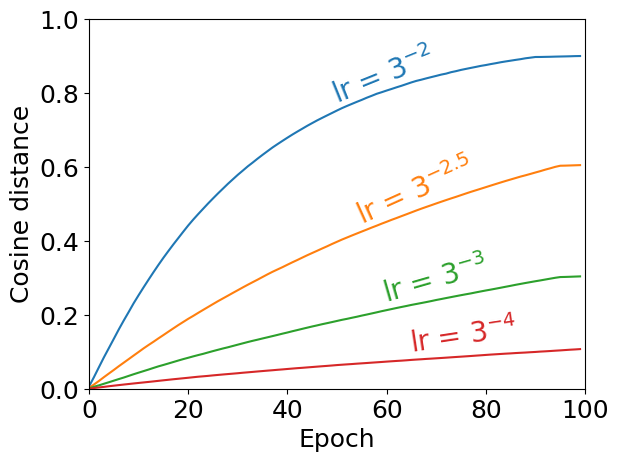

In [68]:
mpld3.disable_notebook()
matplotlib.rcParams.update({'font.size': 18})

lrs = [3**-2,3**-2.5,3**-3,3**-4]
lrs_text = ['lr = $3^{-2}$', 'lr = $3^{-2.5}$', 'lr = $3^{-3}$', 'lr = $3^{-4}$']

results = load_results()
plt.figure()
plt.ylim([0,1])
plt.xlim([0,100])

for i,lr in enumerate(lrs):
    ladc_dense0 = np.array(results[lr]['ladc'])[:,0]
    
    plt.plot(range(len(ladc_dense0)),ladc_dense0)
    
    x_coord = 50+5*i
    diff = 30
    angle = m.atan((ladc_dense0[x_coord+diff]-ladc_dense0[x_coord])/diff*get_aspect())*180/m.pi
    
    plt.annotate(lrs_text[i], xy=(x_coord, ladc_dense0[x_coord]), xycoords='data', color = 'C'+str(i), size = 20,
                 rotation = angle+5, rotation_mode='anchor',
                 xytext = (0,5), textcoords = 'offset points')

plt.xlabel('Epoch')
plt.ylabel('Cosine distance')
plt.show()
plt.savefig('figures/mnist_layer_rotations.png',format='png', dpi=200, bbox_inches="tight")


### Visualize the result

Creating trained features visualization...
Creating initial features visualization...
Creating initial features visualization...


<Figure size 640x480 with 0 Axes>

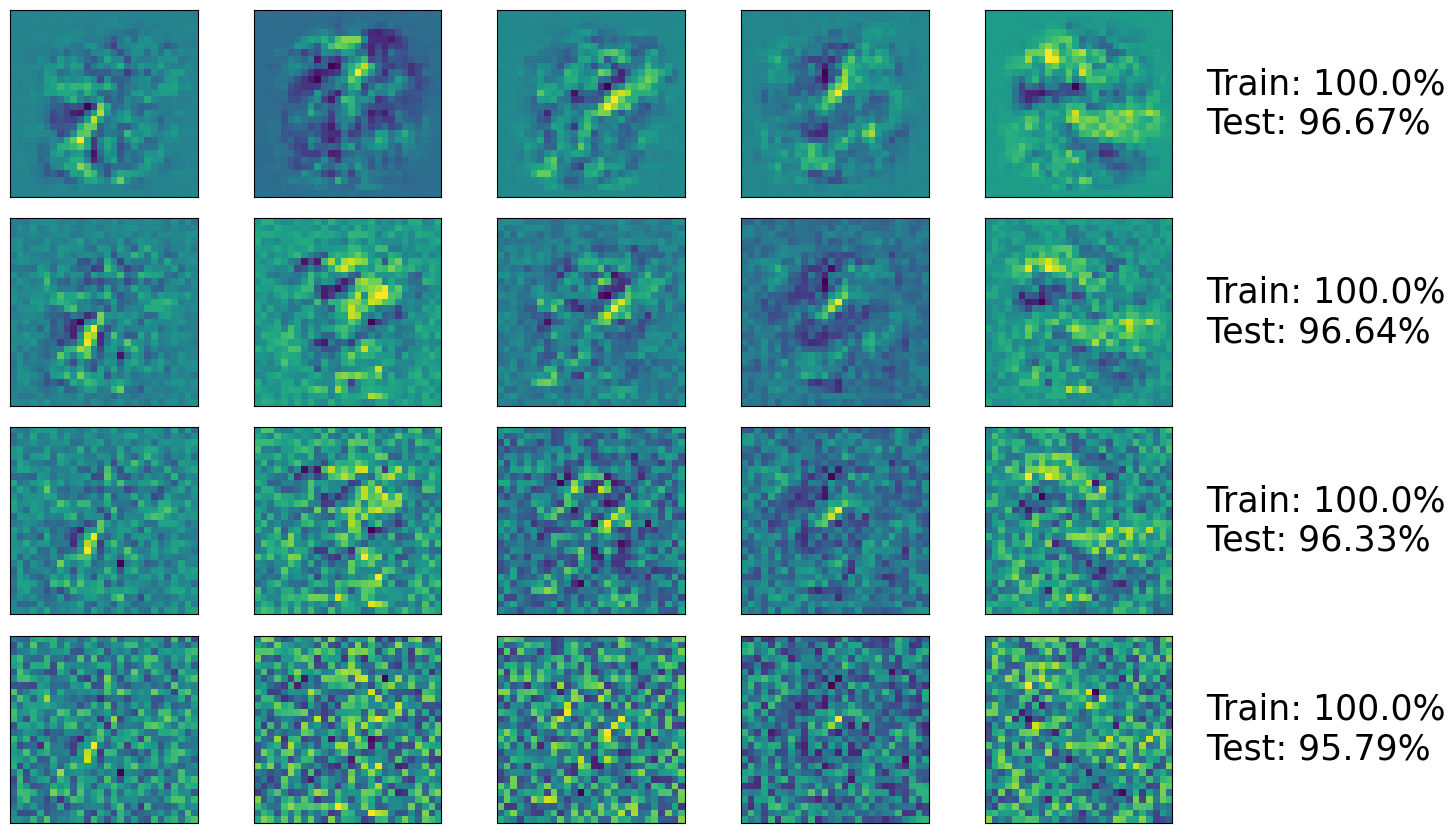

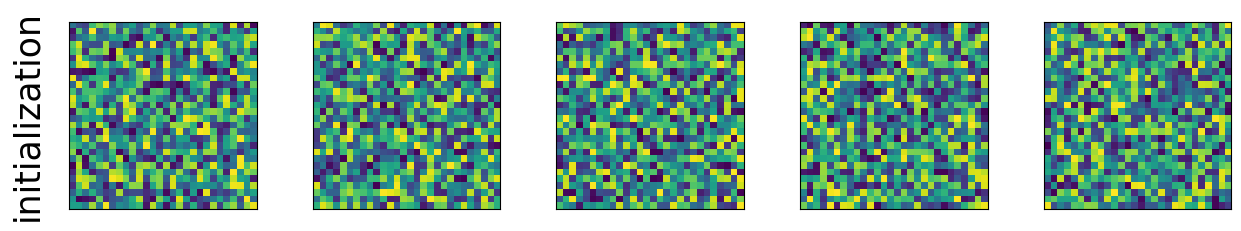

Visualizations complete!


In [69]:
def get_accuracy_metrics(results, lr):
    """Extract accuracy metrics with compatibility for old and new metric names."""
    history = results[lr]['history']['history']
    
    if 'val_acc' in history:
        train_acc = history['acc'][-1]
        val_acc = history['val_acc'][-1]
    else:
        train_acc = history['accuracy'][-1]
        val_acc = history['val_accuracy'][-1]
    
    return train_acc, val_acc

def add_accuracy_annotation(axes, row_idx, train_acc, val_acc, pad=-160):
    """Add accuracy annotation to the rightmost subplot in a row."""
    annotation_text = f' Train: {round(train_acc*100, 2)}%\n Test: {round(val_acc*100, 2)}%'
    
    axes[row_idx, -1].annotate(
        annotation_text,
        xy=(0., 0.5), 
        xytext=(-axes[row_idx, -1].yaxis.labelpad - pad, 0.), 
        xycoords=axes[row_idx, -1].yaxis.label, 
        textcoords='offset points', 
        size=25, 
        ha='left', 
        va='center',
        rotation=0
    )

def visualize_trained_features(lrs, results, model, nb_neurons=5, neuron_indices=range(5,10)):
    """Create visualization of first layer features for different learning rates."""
    mpld3.disable_notebook()
    
    # Create subplot grid
    f, axes = plt.subplots(len(lrs), nb_neurons, 
                          figsize=(nb_neurons*3, len(lrs)*3))
    
    for i, lr in enumerate(lrs):
        # Load model weights for this learning rate
        weights_file = f'saved_weights/{str(round(lr,6))[2:]}.weights.h5'
        model.load_weights(weights_file)
        
        # Get first layer weights
        weights = model.get_weights()[0]
        
        # Visualize weights
        visualize_1stlayer_weights(
            weights,
            nb_neurons=nb_neurons, 
            neuron_indices=neuron_indices,
            neurons_per_line=nb_neurons, 
            axes=axes[i]
        )
        
        # Add accuracy annotation
        train_acc, val_acc = get_accuracy_metrics(results, lr)
        add_accuracy_annotation(axes, i, train_acc, val_acc)
    
    # Adjust layout and save
    plt.subplots_adjust(wspace=0.3, hspace=-0.3)
    plt.savefig('figures/mnist_features_visualization.png', 
                format='png', dpi=200, bbox_inches="tight")
    
    return f, axes

def visualize_initial_features(model, nb_neurons=5, neuron_indices=range(5,10)):
    """Create visualization of initial (untrained) first layer features."""
    # Create subplot for initial weights
    f, axes = plt.subplots(1, nb_neurons, figsize=(nb_neurons*3, 3))
    
    # Load initial weights
    model.load_weights('saved_weights/mnist_initial_weights.weights.h5')
    weights = model.get_weights()[0]
    
    # Visualize initial weights
    visualize_1stlayer_weights(
        weights,
        nb_neurons=nb_neurons, 
        neuron_indices=neuron_indices,
        neurons_per_line=nb_neurons, 
        axes=axes
    )
    
    # Add initialization label
    pad = 10
    axes[0].annotate(
        'initialization', 
        xy=(0, 0.5), 
        xytext=(-axes[0].yaxis.labelpad - pad, 0),
        xycoords=axes[0].yaxis.label, 
        textcoords='offset points',
        size=25, 
        ha='right', 
        va='center',
        rotation=90
    )
    
    # Adjust layout
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    plt.savefig('figures/mnist_initialization_visualization.png',
                format='png', dpi=200, bbox_inches="tight")
    
    return f, axes

# Main execution
def main():
    """Main function to create both visualizations."""
    # Configuration
    lrs = [3**-2, 3**-2.5, 3**-3, 3**-4]
    nb_neurons = 5
    neuron_indices = range(5, 10)
    
    # Load data and model
    results = load_results()
    model = get_model()
    
    # Create visualizations
    print("Creating trained features visualization...")
    trained_fig, trained_axes = visualize_trained_features(
        lrs, results, model, nb_neurons, neuron_indices
    )
    
    print("Creating initial features visualization...")
    initial_fig, initial_axes = visualize_initial_features(
        model, nb_neurons, neuron_indices
    )
    
    print("Visualizations complete!")

# Execute the main function
main()

### Discrepancies
- Final cosine distance doesn’t fully reach ~1 and small differences in absolute test accuracy. These are plausibly due to LR decay timing and subtle Layca step details, not a contradiction of the paper.
- The test accuracy in my results is a little different, about 96–97%. This is close but not exactly the same as the numbers shown in the paper